In [1]:
from __future__ import division, print_function
from comet_ml import Experiment
import numpy as np
from numpy import inf, ndarray
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import keras
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
import re
from keras import optimizers
from keras import losses
from keras import regularizers
import keras.backend as K
from keras.models import model_from_json
from keras.models import load_model, Model
from tempfile import TemporaryFile
from keras import layers
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
# matplotlib inline
from keras.callbacks import History, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation
from keras.layers import CuDNNLSTM, Dense, Bidirectional, Dropout, Layer
from keras.initializers import glorot_normal
from keras.regularizers import l2
from functools import partial
from multiprocessing import cpu_count, Pool
from keras.utils.generic_utils import Progbar
from copy import deepcopy
from NGF.utils import filter_func_args, mol_shapes_to_dims
import NGF.utils
import NGF_layers.features
import NGF_layers.graph_layers
from NGF_layers.features import one_of_k_encoding, one_of_k_encoding_unk, atom_features, bond_features, num_atom_features, num_bond_features
from NGF_layers.features import padaxis, tensorise_smiles, concat_mol_tensors
from NGF_layers.graph_layers import temporal_padding, neighbour_lookup, NeuralGraphHidden, NeuralGraphOutput
from math import ceil
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import networkx as nx
#from networkx.drawing.nx_agraph import graphviz_layout
from argparse import Namespace
import ast
import pickle
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from scipy.spatial.distance import jensenshannon, cosine, pdist

from tqdm.auto import tqdm
import sys
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


# UGRAPHEMP Implementation using GED

In [3]:
samples_all=pd.read_csv("samples_all.csv",index_col=0).reset_index(drop=True)

In [4]:
prot_path = 'lc_embeddings_raw.pkl'
prot_dict = {}
with open(prot_path, 'rb') as f:
    prot_dict = pickle.load(f)
    
prot_dict['Perturbation'] = np.zeros((384,))
prot_dict['IKBKAP'] = np.zeros((384,))
prot_dict['WHSC1'] = np.zeros((384,))
prot_dict['ADRBK1'] = np.zeros((384,))
prot_dict['FIGF'] = np.zeros((384,))
prot_dict['FAM175A'] = np.zeros((384,))
prot_dict['PARK2'] = np.zeros((384,))
prot_dict['NKX3~1'] = np.zeros((384,))
prot_dict['ERBB2IP'] = np.zeros((384,))

shapes_dict = {
    'num_prot_features' : 385,
    'num_edge_features' : 1
}

In [5]:
prot_go_enc=pd.read_csv("../deepSNEM/data/prot_embeddings/bp_features.csv")
shapes_dict = {
    'num_prot_features' : 1040,
    'num_edge_features' : 1
}
prot_dict={}
for i in range(len(prot_go_enc)):
    prot_dict.update({list(prot_go_enc.iloc[i])[0]:np.array(list(prot_go_enc.iloc[i])[1:len(list(prot_go_enc.iloc[i]))])})
prot_dict['Perturbation'] = np.zeros((1039,))   

In [6]:
graphs_location='/home/biolab/Documents/deepsnem_drive/data/'

In [7]:
def df_to_nx(df):
    flag=False
    net=nx.DiGraph()
    nodes=list(set(list(df['node1']) + list(df['node2'])))
    if "Perturbation" not in nodes:
        nodes.append("Perturbation")
        flag=True
    for i in range(len(nodes)):
        if ((nodes[i]=="Perturbation") and flag):
            net.add_node(nodes[i],act=0)
        elif nodes[i] in list(df['node1']):
            j=list(df['node1']).index(nodes[i])
            a=int(list(df['activity1'])[j])
            net.add_node(nodes[i],act=a)
        else:
            j=list(df['node2']).index(nodes[i])
            a=int(list(df['activity2'])[j])
            net.add_node(nodes[i],act=a)
    for i in range(len(df)):
        net.add_edge(df['node1'][i], df['node2'][i], weight=df['sign'][i])
    
    return(net)

In [6]:
def FastGEDEstimate(G1, G2):
    import networkx as nx
    #from networkx.drawing.nx_agraph import graphviz_layout
    import numpy as np
    from numpy import inf, ndarray
    import pandas as pd
    ged=0
    G_new=G1
    G_source=G2
    if len(list(G1.nodes()))>len(list(G2.nodes())):
        G_new=G2
        G_source=G1
    node_list_new=list(G_new.nodes())
    node_list_source=list(G_source.nodes())
    tomod=[elem for elem in node_list_source if (elem not in node_list_new)]
    toadd=[elem  for elem in node_list_new if (elem not in node_list_source)]
    #if (len(tomod)>=len(toadd)):
    ind=list(np.random.choice(len(tomod), len(toadd)))
    ged=len(tomod)+ged
    ordered_new=[x[1] for x in list(nx.bfs_tree(G_new, 'Perturbation').edges())]
    for i in list(nx.bfs_tree(G_source, 'Perturbation').edges()):
        if (i[1] in tomod):
            add=[x for x in ordered_new if x in toadd]
            if add!=[]:
                toadd.remove(add[0])
                tomod.remove(i[1])
                mapping = {i[1]:add[0]} 
                G_source= nx.relabel_nodes(G_source, mapping)
                G_source.nodes(data=True)[add[0]]['act']=G_new.nodes(data=True)[add[0]]['act']
        if toadd==[]:
            break
    for i in tomod:
        G_source.remove_node(i)
    rem1=[]
    rem2=[]
    for n1,n2,attr in G_source.edges(data=True):
        if (not G_new.has_edge(n1,n2)):
            #if G_source[n1][n2]['weight']==G_new[n1][n2]['weight']:
            ged=ged+1
            rem1.append(n1)
            rem2.append(n2)
    for i in range(len(rem1)):
        G_source.remove_edge(rem1[i], rem2[i])
    add1=[]
    add2=[]
    for n1,n2,attr in G_new.edges(data=True):
        if (not G_source.has_edge(n1,n2)):
            #if G_source[n1][n2]['weight']==G_new[n1][n2]['weight']:
            ged=ged+1
            add1.append(n1)
            add2.append(n2)
    for i in range(len(add1)):
        G_source.add_edge(add1[i], add2[i],weight=G_new[add1[i]][add2[i]]['weight'])
    for n1,n2,attr in G_source.edges(data=True):
        if ((G_source.nodes(data=True)[n1]!={}) and G_new.nodes(data=True)[n1]!={}):
            if (abs((G_source.nodes(data=True)[n1]['act']-G_new.nodes(data=True)[n1]['act'])/G_new.nodes(data=True)[n1]['act'])*100>20):
                ged=ged+1
                G_source.nodes(data=True)[n1]['act']=G_new.nodes(data=True)[n1]['act']
        if ((G_source.nodes(data=True)[n2]!={}) and G_new.nodes(data=True)[n2]!={}):
            if (abs((G_source.nodes(data=True)[n2]['act']-G_new.nodes(data=True)[n2]['act'])/G_new.nodes(data=True)[n2]['act'])*100>20):
                ged=ged+1
                G_source.nodes(data=True)[n2]['act']=G_new.nodes(data=True)[n2]['act']
        if (abs((G_source[n1][n2]['weight']-G_new[n1][n2]['weight'])/G_new[n1][n2]['weight'])*100>20):
            ged=ged+1
            G_source[n1][n2]['weight']=G_new[n1][n2]['weight']

    #return([G_source,ged])
    return(ged)

In [7]:
def GEDgenerator(bs,df_pairs,graphs_location,init_count):
    import numpy as np
    #counter=int(0)
    counter=int(init_count)
    #Keep looping indefinetely
    while counter<len(df_pairs):
        ged=[]
        while len(ged)<bs:
            # check to see if you reached the end of the frame
            if counter==len(df_pairs):
                break
            
            p1=graphs_location+df_pairs['graph.x'][counter]
            p2=graphs_location+df_pairs['graph.y'][counter]
            graph_df1=pd.read_csv(p1,index_col=0).reset_index(drop=True)
            graph_df2=pd.read_csv(p2,index_col=0).reset_index(drop=True)
            ged.append(FastGEDEstimate(df_to_nx(graph_df1),df_to_nx(graph_df2)))
            counter=counter+1
    
        
        yield(ged)

In [45]:
df_pairs=pd.read_csv("df_weighted.csv",index_col=0).reset_index(drop=True)

In [47]:
bs=10000
pr_steps=int(len(df_pairs)/bs)
lp=round(pr_steps/10)

In [48]:
pr_steps

3087

In [31]:
GedGen=GEDgenerator(bs,df_pairs,graphs_location,init_count=0)
ged=[]
cn=0
for g in range(pr_steps):
    d=list(next(GedGen))
    ged=ged+d
    if (g%lp==0):
        cn+=1
    print("Steps: "+str(g+1)+"/"+str(pr_steps)+" ["+"-"*cn, end="\r", flush=True)
    np.savetxt("weighted_ged.csv", ged)    
print("Steps: "+str(g+1)+"/"+str(pr_steps)+"["+"-"*cn+"]", end="\r", flush=True)
np.savetxt("weighted_ged.csv", ged)

In [37]:
ged=pd.read_csv("weighted_ged.csv",index_col=0).reset_index(drop=True)

In [39]:
ged=list(ged['V1'])

In [40]:
len(ged)

4604095

In [41]:
ged=np.array(ged)
np.save("weighted_ged.npy", ged)

(array([9.700000e+01, 6.400000e+01, 2.988000e+03, 1.081180e+05,
        6.130870e+05, 8.458340e+05, 1.771547e+06, 1.133279e+06,
        1.276280e+05, 1.453000e+03]),
 array([  1. ,  24.6,  48.2,  71.8,  95.4, 119. , 142.6, 166.2, 189.8,
        213.4, 237. ]),
 <a list of 10 Patch objects>)

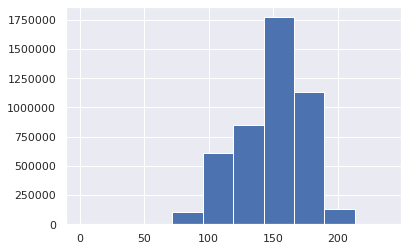

In [42]:
plt.hist(ged)

# Trials

In [ ]:
ged=[]
cn=0
for i in range(len(df_pairs)):
    p1=graphs_location+df_pairs['graph.x'][i]
    p2=graphs_location+df_pairs['graph.y'][i]
    graph_df1=pd.read_csv(p1,index_col=0).reset_index(drop=True)
    graph_df2=pd.read_csv(p2,index_col=0).reset_index(drop=True)
    ged.append(FastGEDEstimate(df_to_nx(graph_df1),df_to_nx(graph_df2)))
    df_pairs['value'][i]=ged[i]
    if (i%(0.1*len(df_pairs))==0):
        cn+=1
    print("Pairs: "+str(i+1)+"/"+str(len(df_pairs))+" ["+"-"*(cn+1), end="\r", flush=True)
    np.savetxt("samples_all_ged.csv", ged)    
print("Steps: "+str(g+1)+"/"+str(pr_steps)+"["+"-"*(g+1)+"]", end="\r", flush=True)

In [ ]:
ged=np.array(ged)
np.save("samples_all_ged.npy", ged)

In [24]:
def one_loop(i,df_pairs):
    p1=graphs_location+df_pairs['graph.x'][i]
    p2=graphs_location+df_pairs['graph.y'][i]
    graph_df1=pd.read_csv(p1,index_col=0).reset_index(drop=True)
    graph_df2=pd.read_csv(p2,index_col=0).reset_index(drop=True)
    g=FastGEDEstimate(df_to_nx(graph_df1),df_to_nx(graph_df2))
    return g

In [25]:
import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count()
inputs = list(range(len(df_pairs)))

In [ ]:
processed_list = Parallel(n_jobs=num_cores)(delayed(one_loop)(i,df_pairs) for i in inputs)

In [ ]:
np.savetxt("samples_all_ged.csv", processed_list)

In [ ]:
np.save("samples_all_ged.npy", np.array(processed_list))

In [ ]:
df_pairs['value']= processed_list 
df_pairs.to_csv("df_pairs2.csv")

In [ ]:
plt.hist(ged)

In [13]:
import time
start = time.time()
ged=[]
p1=graphs_location+list(samples_all['path_list'])[0]
p2=graphs_location+list(samples_all['path_list'])[1]
graph_df1=pd.read_csv(p1,index_col=0).reset_index(drop=True)
graph_df2=pd.read_csv(p2,index_col=0).reset_index(drop=True)
ged.append(FastGEDEstimate(df_to_nx(graph_df1),df_to_nx(graph_df2)))
end = time.time()
print(end - start)

0.028229713439941406


In [15]:
(end - start)*16000000/3600

125.46539306640625

In [ ]:
#Load pairs
df_pairs=pd.read_csv("",index_col=0).reset_index(drop=True)

In [241]:
ged=[]
for i in range(len(df_pairs)):
    p1=graphs_location+df_pairs['path_list1'][i]
    p2=graphs_location+df_pairs['path_list2'][i]
    graph_df1=pd.read_csv(p1,index_col=0).reset_index(drop=True)
    graph_df2=pd.read_csv(p2,index_col=0).reset_index(drop=True)
    ged.append(FastGEDEstimate(df_to_nx(graph_df1),df_to_nx(graph_df2)))
    if i%int(0.1*len(df_pairs))==0:
        print('Running: %s'%(i/len(df_pairs)))
np.save("samples_all_ged.npy", np.array(ged))
    #X_prots, X_edgeattr, X_edges=tensorize_signalnet(df_to_nx(graph_df),prot_dict,100,21,shapes_dict)

In [ ]:
np.savetxt("samples_all_ged.csv", ged)

In [8]:
def tensorize_signalnet(netx_list,prot_dict,max_prots,max_degree,shapes_dict):
    import numpy as np
    n = len(netx_list)
    X_prots= np.zeros((n,max_prots,shapes_dict['num_prot_features']),dtype='float32')
    Χ_edgattr=np.zeros((n,max_prots,max_degree,shapes_dict['num_edge_features']),dtype='float32')
    X_edges=np.ones((n,max_prots,max_degree),dtype='int32')*int(-1)
    for idx,netx in enumerate(netx_list):
        for i,p in enumerate(list(netx.nodes())):
            l=list(prot_dict[p])
            l.append(netx.nodes[p]['act'])
            X_prots[idx][i]=np.array(l)
            inds=[list(netx.nodes()).index(x) for x in list(netx[p])[0:max_degree]]
            attrs=[netx[p][x]['weight'] for x in list(netx[p])[0:max_degree]]
            if len(inds)<max_degree:
                for j in range(max_degree-len(inds)):
                    inds.append(-1)
                    attrs.append(0)
            X_edges[idx][i]=np.array(inds)
            Χ_edgattr[idx][i]=np.array(attrs).reshape(21,1)
    
    return X_prots,Χ_edgattr,X_edges

In [9]:
df_pairs=pd.read_csv("df_pairs.csv",index_col=0).reset_index(drop=True)

/home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [102]:
p=[graphs_location+x for x in list(df_pairs['graph.x'])[0:10]]
graph_df=[pd.read_csv(x,index_col=0).reset_index(drop=True) for x in p]
gg=[df_to_nx(x) for x in graph_df]

In [104]:
X_prots, X_edgeattr, X_edges= tensorize_signalnet(gg,prot_dict,100,21,shapes_dict)

In [120]:
max_prots=100
pax_degree=21

In [243]:
net1=[]
for i in range(10):
    p1=graphs_location+samples_all['path_list'][i]
    graph_df1=pd.read_csv(p1,index_col=0).reset_index(drop=True)
    net1.append(df_to_nx(graph_df1))

In [265]:
yolo=[tensorize_signalnet(net,prot_dict,max_prots,pax_degree,shapes_dict) for net in net1]


In [278]:
X_prots= np.array([x[0] for x in yolo])
X_edgeattr= np.array([x[1] for x in yolo])
X_edges=[x[2] for x in yolo]

In [282]:
X_prots=np.array(X_prots)

In [284]:
X_prots.shape

(10, 100, 385)

In [35]:
def train_generator(bs,df,graphs_location,shapes_dict,prot_dict,max_prots,max_degree):
    import numpy as np
    counter=int(0)
    #Keep looping indefinetely
    while True:
        
        #Initialize batches of inputs and outputs
        net1 = []
        net2 = []
        
        d=[]
        
        #Keep looping until we reach batch size
        while len(net1)<=bs: #doesn't matter if it is smi1 or smi2 since they have the same len
            
            # check to see if you reached the end of the frame
            if counter==len(df):
                counter=int(0)
                df = df.sample(frac=1).reset_index(drop=True)
            
            p1=graphs_location+df['graph.x'][counter]
            p2=graphs_location+df['graph.y'][counter]
            graph_df1=pd.read_csv(p1,index_col=0).reset_index(drop=True)
            graph_df2=pd.read_csv(p2,index_col=0).reset_index(drop=True)
            net1.append(df_to_nx(graph_df1))
            net2.append(df_to_nx(graph_df2))
            
            d.append(df.value[counter])
            counter+=1
            
        #l=[tensorize_signalnet(net,prot_dict,max_prots,max_degree,shapes_dict) for net in net1]
        #X_prots= np.array([x[0] for x in l])
        #X_edgeattr= np.array([x[1] for x in l])
        #X_edges=np.array([x[2] for x in l])
        prot_1,edgattr_1,edge_1=tensorize_signalnet(net1,prot_dict,max_prots,max_degree,shapes_dict)
        #prot_1=np.array(X_prots,dtype = 'float32')
        #edgattr_1=np.array(X_edgeattr[ind1],dtype = 'float32')
        #edge_1=np.array(X_edges,dtype = 'int32')
        #l=[tensorize_signalnet(net,prot_dict,max_prots,max_degree,shapes_dict) for net in net2]
        #X_prots= np.array([x[0] for x in l])
        #X_edgeattr= np.array([x[1] for x in l])
        #X_edges=np.array([x[2] for x in l])
        prot_2,edgattr_2,edge_2=tensorize_signalnet(net2,prot_dict,max_prots,max_degree,shapes_dict)
        #prot_2=np.array(X_prots,dtype = 'float32')
        #edgattr_2=np.array(X_edgeattr,dtype = 'float32')
        #edge_2=np.array(X_edges,dtype = 'int32')
        
        # yield the batch to the calling function
        yield ({'prot_inputs_1':prot_1,'edgattr_inputs_1':edgattr_1,'edge_inputs_1':edge_1,'prot_inputs_2':prot_2,
                'edgattr_inputs_2':edgattr_2,'edge_inputs_2':edge_2},np.array(d,dtype = 'float32'))

In [36]:
##not ready yet
def preds_generator(bs,df_emb,prot_dict,max_prots,max_degree,shapes_dict,model_net):
    
    import numpy as np
    counter=int(0)
    #Keep looping indefinetely
    while counter<len(df_emb):
        
        #Initialize batches of inputs and outputs
        net = []
        
        
        #Keep looping until we reach batch size
        while len(net)<=bs: #doesn't matter if it is smi1 or smi2 since they have the same len
            
            # check to see if you reached the end of the frame
            if counter==len(df_cold):
                break
                
            p=graphs_location+df_emb['files_combined'][counter]
            graph_df=pd.read_csv(p,index_col=0).reset_index(drop=True)
            net.append(df_to_nx(graph_df1))
            counter+=1
    
            
        prot,edgattr,edge=tensorize_signalnet(net,prot_dict,max_prots,max_degree,shapes_dict)
        
        y_pred=model_net.predict([prot,edgattr,edge],batch_size=bs)
        
        yield(y_pred)

In [12]:
max_prots = 100
max_degree = 21
num_prot_features = shapes_dict['num_prot_features']
num_edge_features = shapes_dict['num_edge_features']

# Dictionary and custom metrics

In [13]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

def get_cindex(y_true, y_pred):
    g = tf.subtract(tf.expand_dims(y_pred, -1), y_pred)
    g = tf.cast(g == 0.0, tf.float32) * 0.5 + tf.cast(g > 0.0, tf.float32)

    f = tf.subtract(tf.expand_dims(y_true, -1), y_true) > 0.0
    f = tf.matrix_band_part(tf.cast(f, tf.float32), -1, 0)

    g = tf.reduce_sum(tf.multiply(g, f))
    f = tf.reduce_sum(f)

    return tf.where(tf.equal(g, 0), 0.0, g/f)

def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

def mse_sliced(y_true,y_pred):
    condition = tf.math.less_equal(y_pred,0.2)
    indices = tf.where(condition)
    slice_true = tf.gather_nd(y_true,indices)
    slice_pred = tf.gather_nd(y_pred,indices)
    mse_sliced = K.mean(K.square(slice_pred - slice_true), axis=-1)
    return mse_sliced

def custom_accuracy(y_true,y_pred):
    cat_true = tf.math.less_equal(y_true,0.2)
    cat_pred = tf.math.less_equal(y_pred,0.2)
    casted_true = K.cast(cat_true,"int32")
    casted_pred = K.cast(cat_pred,"int32")
    acc = K.mean(K.equal(casted_true, K.round(casted_pred)))
    return acc

def precision(y_true, y_pred):
        """Precision metric.
        Computes the precision over the whole batch using threshold_value.
        """
        cat_true = tf.math.less_equal(y_true,0.2)
        casted_true = K.cast(cat_true,"float32")
        cat_pred = tf.math.less_equal(y_pred,0.2)
        casted_pred = K.cast(cat_pred,"float32")
        # Compute the number of true positives.
        true_positives = K.sum(tf.math.multiply(casted_true , casted_pred ))
        # count the predicted positives
        predicted_positives = K.sum(casted_pred)
        # Get the precision ratio
        precision_ratio = tf.math.divide(true_positives , predicted_positives + K.epsilon() )
        return precision_ratio

In [14]:
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.log(sigma) + 0.5*tf.div(tf.square(y_true - y_pred), sigma)) + 1e-6
    return gaussian_loss

class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(int(input_shape[-1]), self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(int(input_shape[-1]), self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

class ConGaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(ConGaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(int(input_shape[-1]), self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(int(input_shape[-1]), self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(ConGaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_mu  = keras.layers.ReLU(max_value=1)(output_mu)
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06 
        output_sig_pos  = keras.layers.ReLU(max_value=1)(output_sig_pos) + 1e-06 
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]


def euclidean_distance(x,y):
    #x, y = vects
    #eucl=tf.sqrt(tf.math.reduce_sum(tf.square(tf.subtract(x,y),"Square"),"Sqrt"),axis=1,keepdims=True)
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
    #return eucl


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

class Attention_theta(Layer):
    def __init__(self, **kwargs):
        super(Attention_theta, self).__init__(**kwargs)
    def build(self, input_shape):
        self.theta = self.add_weight(name='theta', 
                                      shape=(int(input_shape[-1]), int(input_shape[-1])),
                                      initializer=glorot_normal(),
                                      trainable=True)
        super(Attention_theta, self).build(input_shape) 
    def call(self, x):
        import numpy as np
        multi1  = K.dot(tf.math.reduce_mean(x,axis=1),self.theta)
        #multi1=tf.transpose(multi1)
        #print(K.int_shape(multi1))
        multi1=Activation('relu')(multi1)
        multi2  = K.batch_dot(x,multi1,axes=(2,1))
        multi2=Activation('sigmoid')(multi2)
        #print(K.int_shape(multi2))
        #print(K.int_shape(x))
        output_emb = K.batch_dot(multi2,x,axes=1)
        output_emb=keras.layers.Reshape((1,K.int_shape(output_emb)[1]))(output_emb)
        #print(K.int_shape(output_emb))
        return output_emb
    def compute_output_shape(self, input_shape):
        return (input_shape[0],1,int(input_shape[-1]))


# Model

In [15]:
p = {'lr': 0.0001,
     'nfilters': int(32),
     'size': int(8),
     'conv_width' : 128,
     'fp_length' : 256,
     'size_drug_1' : 8,
     'size_drug_2' : 4,
     'size_protein_1' : 8,
     'size_protein_2' : 16,
     'size_protein_3' : 3,
     'batch_size': int(128),
     'dense_size': int(256),
     'dense_size_2': 512,
     'dropout': 0.25,
     'l2reg': 0.01}

# Evaluation function

In [16]:
def model_evaluate(y_pred,Y_cold,th,df_cold):
    true = np.reshape(Y_cold,len(df_cold))
    pred = np.reshape(y_pred,len(df_cold))
    cor = np.corrcoef(true,pred)
    mse_all = sklearn.metrics.mean_squared_error(true,pred)
    # calculate mse of similars
    mse_sims = sklearn.metrics.mean_squared_error(true[pred<=th],pred[pred<=th])
    # turn to categorical to calculate precision and accuracy
    true_cat = true <= th
    pred_cat = pred <= th
    pos = np.sum(pred_cat)
    prec = precision_score(true_cat,pred_cat)
    # calculate accuracy
    acc = accuracy_score(true_cat,pred_cat)
    result =pd.DataFrame({'cor' : cor[0,1], 'mse_all' : mse_all, 'mse_similars' : mse_sims,'precision': prec, 'accuracy': acc,
                         'positives' : pos}, index=[0])
    return(result)

# Fit ensembles

In [37]:
def enc_nikos(params, lr_value, conv_width, fp_length):
        
    ### encode smiles
    
    prots0 = Input(name='prot_inputs', shape=(max_prots, num_prot_features),dtype = 'float32')
    edgattrs = Input(name='edgattr_inputs', shape=(max_prots, max_degree, num_edge_features),dtype = 'float32')
    edges = Input(name='edge_inputs', shape=(max_prots, max_degree), dtype='int32')

    #prosoxi arxika to kano 256 ton pinaka
    g1 = NeuralGraphHidden(conv_width , activ = None, bias = True , init = 'glorot_normal')([prots0,edgattrs,edges])
    g1 = BatchNormalization(momentum=0.6)(g1)
    g1 = Activation('relu')(g1)
    g1=keras.layers.Dropout(0.4)(g1)

    g2 = NeuralGraphHidden(int(conv_width/2) , activ = None, bias = True , init = 'glorot_normal')([g1,edgattrs,edges])
    g2 = BatchNormalization(momentum=0.6)(g2)
    g2 = Activation('relu')(g2)
    g2=keras.layers.Dropout(0.4)(g2)

    g3 = NeuralGraphHidden(int(conv_width/2) , activ = None, bias = True , init = 'glorot_normal')([g2,edgattrs,edges])
    g3 = BatchNormalization(momentum=0.6)(g3)
    g3 = Activation('relu')(g3)



    g4=keras.layers.Conv1D(128,37, activation=None, use_bias=False, kernel_initializer='glorot_uniform')(g3)
    g4= BatchNormalization(momentum=0.6)(g4)
    g4 = Activation('relu')(g4)
    g4=keras.layers.Dropout(0.3)(g4)
    
    g5=keras.layers.Conv1D(128,33, activation=None, use_bias=False, kernel_initializer='glorot_uniform')(g4)
    g5= BatchNormalization(momentum=0.6)(g5)
    g5 = Activation('relu')(g5)
    g5=keras.layers.Dropout(0.3)(g5)
    
    g6=keras.layers.Conv1D(128,32, activation=None, use_bias=False, kernel_initializer='glorot_uniform')(g5)
    g6= BatchNormalization(momentum=0.6)(g6)
    g6 = Activation('relu')(g6)
    g6=keras.layers.Dropout(0.3)(g6)
    g6=keras.layers.Flatten()(g6)


    interactionModel = keras.Model(inputs=[prots0, edgattrs, edges], outputs= g6)

    print(interactionModel.summary())
    return interactionModel

In [38]:
# Initialize encoder
encoder_nikos = enc_nikos(p, 0.001, 256, 256)

# Initialize model
prots0_1 = Input(name='atom_inputs_1', shape=(max_prots, num_prot_features),dtype = 'float32')
edgattr_1 = Input(name='edgattr_inputs_1', shape=(max_prots, max_degree, num_edge_features),dtype = 'float32')
edges_1 = Input(name='edge_inputs_1', shape=(max_prots, max_degree), dtype='int32')

prots0_2 = Input(name='atom_inputs_2', shape=(max_prots, num_prot_features),dtype = 'float32')
edgattr_2 = Input(name='edgattr_inputs_2', shape=(max_prots, max_degree, num_edge_features),dtype = 'float32')
edges_2 =Input(name='edge_inputs_2', shape=(max_prots, max_degree), dtype='int32')

encoded_1 = encoder_nikos([prots0_1,edgattr_1,edges_1])
#encoded_1 =keras.layers.Flatten()(encoded_1)
encoded_2 = encoder_nikos([prots0_2,edgattr_2,edges_2])
#encoded_2 = keras.layers.Flatten()(encoded_2)

L1_layer = keras.layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_1, encoded_2])

mu, sigma = ConGaussianLayer(1, name='main_output')(L1_distance)

siamese_net = Model(inputs=[prots0_1,edgattr_1,edges_1,prots0_2,edgattr_2,edges_2],outputs=mu)
print(siamese_net.summary())
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
siamese_net.compile(optimizer= adam,loss= custom_loss(sigma),metrics=['mse', get_cindex, r_square, pearson_r])

# Train with fitgen
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=2, min_lr=0.00001, verbose=1, min_delta=1e-5)
term=keras.callbacks.TerminateOnNaN()
bs=512
NUM_EPOCHS = 5
df_pairs = df_pairs.sample(frac=1).reset_index(drop=True)
#Set total number of training samples and tests samples
NUM_TRAIN = len(df_pairs)
trainGen=train_generator(bs,df_pairs,graphs_location,shapes_dict,prot_dict,max_prots,max_degree)
history = siamese_net.fit_generator(trainGen,
                                    steps_per_epoch= ceil(NUM_TRAIN/bs),
                                    epochs=NUM_EPOCHS,
                                    verbose = 1,
                                    shuffle = True,
                                    callbacks= [term, rlr])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
prot_inputs (InputLayer)        (None, 100, 1040)    0                                            
__________________________________________________________________________________________________
edgattr_inputs (InputLayer)     (None, 100, 21, 1)   0                                            
__________________________________________________________________________________________________
edge_inputs (InputLayer)        (None, 100, 21)      0                                            
__________________________________________________________________________________________________
neural_graph_hidden_21 (NeuralG (None, 100, 256)     5601792     prot_inputs[0][0]                
                                                                 edgattr_inputs[0][0]             
          

Epoch 1/5


KeyError: 'IKBKAP'

In [ ]:
# Train with fitgen
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=2, min_lr=0.00001, verbose=1, min_delta=1e-5)
term=keras.callbacks.TerminateOnNaN()
bs=512
NUM_EPOCHS = 5
df = df.sample(frac=1).reset_index(drop=True)
#Set total number of training samples and tests samples
NUM_TRAIN = len(df)
trainGen=train_generator(bs,df,smiles,X_atoms, X_bonds, X_edges)
history = siamese_net.fit_generator(trainGen,
                                    steps_per_epoch= ceil(NUM_TRAIN/bs),
                                    epochs=NUM_EPOCHS,
                                    verbose = 1,
                                    shuffle = True,
                                    callbacks= [term, rlr])

In [ ]:
graphs_to_emb=pd.read_csv("samples_seen.csv",index_col=0).reset_index(drop=True)

In [ ]:
siamese_net.save_weights("Ugraphemp/models/siamese_model.h5")
encoder_nikos.save_weights("Ugraphemp/models/encoder_model.h5")
#gaussian = keras.Model(siamese_net.inputs, siamese_net.get_layer('main_output').output)
pr_steps=ceil(len(graphs_to_emb)/2048)
PredGen=preds_generator(2048,graphs_to_emb,prot_dict,max_prots,max_degree,shapes_dict,encoder_nikos)
y_pred=[]
for g in range(pr_steps):
    y_pred=y_pred+list(next(PredGen))
y_pred=np.array(y_pred)
np.save("Ugraphemp/models/ugraph_seen_emb1.npy",y_pred)
np.savetxt("Ugraphemp/models/ugraph_seen_emb1.csv",y_pred)

In [ ]:
samples_all

In [ ]:
siamese_net.save_weights("Ugraphemp/models/siamese_model.h5")
encoder_nikos.save_weights("Ugraphemp/models/encoder_model.h5")
#gaussian = keras.Model(siamese_net.inputs, siamese_net.get_layer('main_output').output)
pr_steps=ceil(len(samples_all)/2048)
PredGen=preds_generator(2048,samples_all,prot_dict,max_prots,max_degree,shapes_dict,encoder_nikos)
y_pred=[]
for g in range(pr_steps):
    y_pred=y_pred+list(next(PredGen))
y_pred=np.array(y_pred)
np.save("Ugraphemp/models/ugraph_samples_all_emb1.npy",y_pred)
np.savetxt("Ugraphemp/models/ugraph_samples_all_emb1.csv",y_pred)

# Example for pravious projects

In [ ]:
for i in [4]:
    
    #Load data
    df = pd.read_csv("a375/" + "fold_%s/train_%s.csv" %(i+1,i+1),index_col=0).reset_index(drop=True)
    smiles=list(set(list(df['rdkit.x'])+list(df['rdkit.y'])))
    X_atoms, X_bonds, X_edges = tensorise_smiles(smiles, max_degree, max_atoms)
    df_cold = pd.read_csv("a375/" + "fold_%s/val_%s.csv" %(i+1,i+1),index_col=0).reset_index(drop=True)
    smiles_cold = list(set(list(df_cold['rdkit.x'])+list(df_cold['rdkit.y'])))
    X_atoms_cold, X_bonds_cold, X_edges_cold = tensorise_smiles(smiles_cold, max_degree=5, max_atoms = 60)
    Y_cold = df_cold.value/2
    
    n=8
    cold_preds_mus = []
    cold_preds_sigmas = []
    while n<10:
        
        # Initialize encoder
        encoder_nikos = enc_nikos(p, 0.001, 128, 256)
    
        # Initialize model
        prots0_1 = Input(name='atom_inputs_1', shape=(max_prots, num_prot_features),dtype = 'float32')
        edgattr_1 = Input(name='edgattr_inputs_1', shape=(max_prots, max_degree, num_edge_features),dtype = 'float32')
        edges_1 = Input(name='edge_inputs_1', shape=(max_prots, max_degree), dtype='int32')

        prots0_2 = Input(name='atom_inputs_2', shape=(max_prots, num_prot_features),dtype = 'float32')
        edgattr_2 = Input(name='edgattr_inputs_2', shape=(max_prots, max_degree, num_edge_features),dtype = 'float32')
        edges_2 =Input(name='edge_inputs_2', shape=(max_prots, max_degree), dtype='int32')

        encoded_1 = encoder_nikos([prots0_1,edgattr_1,edges_1])
        #encoded_1 =keras.layers.Flatten()(encoded_1)
        encoded_2 = encoder_nikos([prots0_2,edgattr_2,edges_2])
        #encoded_2 = keras.layers.Flatten()(encoded_2)

        #K dot
        #product_layer=keras.layers.Lambda(lambda tensors:tf.linalg.trace(K.batch_dot(tensors[0],tensors[1],axes=2)))
        #product_layer=keras.layers.Lambda(lambda tensors:tf.reduce_sum(K.batch_dot(tensors[0],tensors[1],axes=2),[1, 2]))
        product_layer=keras.layers.Lambda(lambda tensors:K.batch_dot(tensors[0],tensors[1],axes=2))
        product=product_layer([encoded_1, encoded_2])

        c1=keras.layers.Conv1D(128, 32, activation=None, use_bias=False, kernel_initializer='glorot_uniform')(product)
        c1= BatchNormalization(momentum=0.6)(c1)
        c1= Activation('relu')(c1)
        c1=keras.layers.Dropout(0.25)(c1)
        c1=keras.layers.Flatten()(c1)


        mu, sigma = GaussianLayer(1, name='main_output')(c1)


        siamese_net = Model(inputs=[prots0_1,edgattr_1,edges_1,prots0_2,edgattr_2,edges_2],outputs=mu)
        print(siamese_net.summary())
        adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
        siamese_net.compile(optimizer= adam,loss= custom_loss(sigma),metrics=['mse', get_cindex, r_square, pearson_r])

        # Train with fitgen
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=2, min_lr=0.00001, verbose=1, min_delta=1e-5)
        term=keras.callbacks.TerminateOnNaN()
        bs=128
        NUM_EPOCHS = 20
        df = df.sample(frac=1).reset_index(drop=True)
        #Set total number of training samples and tests samples
        NUM_TRAIN = len(df)
        trainGen=train_generator(bs,df,smiles,X_atoms, X_bonds, X_edges)
        history = siamese_net.fit_generator(trainGen,
                                            steps_per_epoch= ceil(NUM_TRAIN/bs),
                                            epochs=NUM_EPOCHS,
                                            verbose = 1,
                                            shuffle = True,
                                            callbacks= [term, rlr])
        
        if history.history["r_square"][len(history.history["r_square"])-1] < 0.7:
            history = siamese_net.fit_generator(trainGen,
                                             steps_per_epoch= ceil(NUM_TRAIN/bs),
                                             epochs = 10,
                                             verbose = 1,
                                             shuffle = True,
                                             callbacks= [term, rlr])
        if history.history["r_square"][len(history.history["r_square"])-1] >= 0.7:
            siamese_net.save_weights("a375/results/" + "fold_%s/models/"%(i+1) + "model_%s.h5"%n)
            gaussian = keras.Model(siamese_net.inputs, siamese_net.get_layer('main_output').output)
            pr_steps=ceil(len(df_cold)/2048)
            PredGen=preds_generator(2048,df_cold,smiles_cold,X_atoms_cold, X_bonds_cold, X_edges_cold,gaussian)
            y_pred1=[]
            y_pred2=[]
            for g in range(pr_steps):
                cold_pred=list(next(PredGen))
                y_pred1=y_pred1+list(cold_pred[0])
                y_pred2=y_pred2+list(cold_pred[1])
            y_pred1=np.array(y_pred1)
            y_pred2=np.array(y_pred2)
            if (len(y_pred1[np.where(y_pred1 <= 0.2)])>0):
                get = model_evaluate(y_pred1,Y_cold,0.2,df_cold)
                get.to_csv("a375/results/" + "fold_%s/performance/"%(i+1) + "model_%s.csv"%n)
            cold_preds_mus.append(y_pred1)
            np.save("a375/results/"+ "fold_%s/cold/mu/"%(i+1) + "cold_mu_%s.npy"%n, y_pred1)
            cold_preds_sigmas.append(y_pred2)
            np.save("a375/results/" + "fold_%s/cold/sigma/"%(i+1) + "cold_sigma_%s.npy"%n, y_pred2)
            n=n+1
    
    mu_star=np.mean(cold_preds_mus,axis=0)
    sigma_star = np.sqrt(np.mean(cold_preds_sigmas + np.square(cold_preds_mus), axis = 0) - np.square(mu_star))
    cv_star = sigma_star/mu_star
    if (len(mu_star[np.where(mu_star <= 0.2)])>0):
        get_fold = model_evaluate(mu_star,Y_cold,0.2,df_cold)
        get_fold.to_csv("a375/results/" + "fold_%s/ensemble_performance.csv"%(i+1))
    df_cold['mu'] = mu_star
    df_cold['cv'] = cv_star
    df_cold.to_csv("a375/results/" + "fold_%s/ensemble_preds_dataframe.csv"%(i+1))

In [ ]:
cold_preds_mus = []
cold_preds_sigmas = []
for n in range(10):
    cold_preds_mus.append(np.load("a375/results/fold_5/cold/mu/cold_mu_%s.npy"%n))
    cold_preds_sigmas.append(np.load("a375/results/fold_5/cold/sigma/cold_sigma_%s.npy"%n))

mu_star=np.mean(cold_preds_mus,axis=0)
sigma_star = np.sqrt(np.mean(cold_preds_sigmas + np.square(cold_preds_mus), axis = 0) - np.square(mu_star))
cv_star = sigma_star/mu_star
if (len(mu_star[np.where(mu_star <= 0.2)])>0):
    get_fold = model_evaluate(mu_star,Y_cold,0.2,df_cold)
    get_fold.to_csv("a375/results/fold_5/ensemble_performance.csv")
    df_cold['mu'] = mu_star
    df_cold['cv'] = cv_star
    df_cold.to_csv("a375/results/fold_5/ensemble_preds_dataframe.csv")

In [ ]:
get_fold_all={'cor' : [], 'mse_all' : [], 'mse_similars' : [],'precision': [], 'accuracy': [],'positives' : []}

In [ ]:
for i in range(1,6):
    get=pd.read_csv("a375/results/fold_%s/ensemble_performance.csv"%i,index_col=0)
    get_fold_all['cor'].append(get['cor'][0])
    get_fold_all['mse_all'].append(get['mse_all'][0])
    get_fold_all['mse_similars'].append(get['mse_similars'][0])
    get_fold_all['precision'].append(get['precision'][0])
    get_fold_all['accuracy'].append(get['accuracy'][0])
    get_fold_all['positives'].append(get['positives'][0])

In [ ]:
get_fold_all=pd.DataFrame(get_fold_all)

In [ ]:
get_fold_all

In [ ]:
pd.DataFrame({'cor' : get_fold_all['cor'].mean(), 'mse_all' : get_fold_all['mse_all'].mean(), 'mse_similars' : get_fold_all['mse_similars'].mean(),
              'precision': get_fold_all['precision'].mean(), 'accuracy': get_fold_all['accuracy'].mean(),'positives' : ceil(get_fold_all['positives'].mean())}, index=[0]).to_csv("a375/results/cross_ensemble_performance.csv")

In [ ]:
pd.DataFrame({'cor' : get_fold_all['cor'].mean(), 'mse_all' : get_fold_all['mse_all'].mean(), 'mse_similars' : get_fold_all['mse_similars'].mean(),
              'precision': get_fold_all['precision'].mean(), 'accuracy': get_fold_all['accuracy'].mean(),'positives' : ceil(get_fold_all['positives'].mean())}, index=[0])

# General stuff

In [ ]:
def net2json(df):
    nodes=list(set(list(df['node1']) + list(df['node2'])))
    #read pickle in the folder you are
    #import pickle
    #filep=open('ReSimNet-Dataset.pkl','rb')
    #prot_enc=pickle.load(filep)
    #filep.close()
    if "Perturbation" in nodes:
        nodes.remove("Perturbation")
    #nodes[nodes.index("Perturbation")]=nodes[0]
    #nodes[0]="Perturbation"
    feats={}
    for j,x in enumerate(nodes):
        if (x in list(df['node1'])):
            activity=list(df['activity1'])[list(df['node1']).index(x)]
        else:
            activity=list(df['activity2'])[list(df['node2']).index(x)]
        sign = lambda a: '-' if (int(a)==-1) else '+'
        feats.update({"%s"%j:x+sign(activity)})
    net={}
    net.update({"edges":[]})
    net.update({"features":feats})
    for j in range(1,len(df)):
        if ((df['node1'][j]!="Perturbation") and (df['node2'][j]!="Perturbation")):
            ind1=nodes.index(df['node1'][j])
            ind2=nodes.index(df['node2'][j])
            net["edges"].append([ind1,ind2])
    return(net)

In [ ]:
info=pd.read_csv("file_info.csv",index_col=0)

In [297]:
#find how to copy file in python
#from shutil import copyfile
import json
path_list=[]
embed_id=[]
prev_sig=[]
counter=0
for (i in range(len(info))):
    if (info['sig_id'][i] not in prev_sig):
        #copyfile(info['files_combined'][i], "drive/My Drive/Computational_projects/deepsnem/graph2vec")
        path_list.append(info['files_combined'][i])
        embed_id.append(info['emb'][i])
        prev_sig.append(info['sig_id'][i])
        counter+=1
    if counter==7788:
        break
for (i,x in enumerate(path_list)):
    df=pd.read_csv(x,index_col=0)
    net=net2json(df)
    with open('carn_data/'+embed_id[i]+'.json', 'w') as fp:
        json.dump(net, fp)

In [305]:
def getMCS(G_source, G_new):
    matching_graph=nx.Graph()

    for n1,n2,attr in G_new.edges(data=True):
        if G_source.has_edge(n1,n2) :
            if G_source[n1][n2]['weight']==G_new[n1][n2]['weight']:
                matching_graph.add_edge(n1,n2,weight=attr)

    graphs = list(nx.connected_components(matching_graph))

    mcs_length = 0
    mcs_graph = nx.Graph()
    for i, graph in enumerate(graphs):

        if len(graph) > mcs_length:
            mcs_length = len(graph)
            mcs_graph = graph

    return [mcs_length,mcs_graph]